# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных<br>**

id — уникальный идентификатор скважины;<br>
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).<br>

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.<br>
Бюджет на разработку скважин в регионе — 10 млрд рублей.<br>
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.<br>

**План выполнения проекта**

Загрузим и подготовим данные. <br>
Обучим и проверим модель для каждого региона: <br>
2.1. Разобьем данные на обучающую и валидационную выборки в соотношении 75:25. <br>
2.2. Обучим модель и сделаем предсказания на валидационной выборке. <br>
2.3. Сохраним предсказания и правильные ответы на валидационной выборке. <br>
2.4. Найдем средний запас предсказанного сырья и RMSE модели. <br>
2.5. Проанализируем результаты. <br>

Расчет прибыли: <br>
3.1. Все ключевые значения для расчётов сохраним в отдельных переменных. <br>
3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.  <br>Сравним полученный объём сырья со средним запасом в каждом регионе. <br>

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели: <br>
4.1. Выберем скважины с максимальными значениями предсказаний. <br>
4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям. <br>
4.3. Рассчитаем прибыль для полученного объёма сырья. <br>

Риски и прибыль для каждого региона: <br>
5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
5.2. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль. <br>
5.3. Обоснуем выбор региона для разработки скважин. <br>

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

Изучим данные таблиц

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')

In [3]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')

In [4]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Каждый датасет содержит 100 000 записей без пропусков. 

In [8]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [9]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [10]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Для начала рассмотрим распределение целевого признака. 

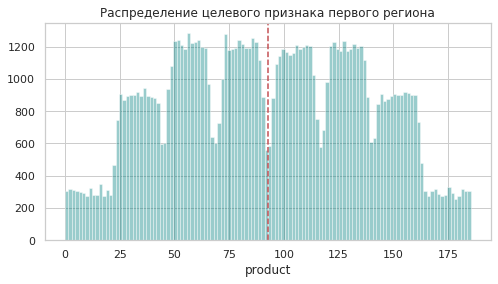

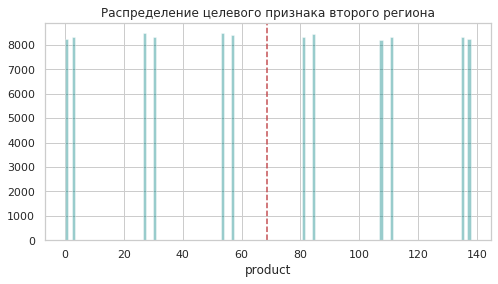

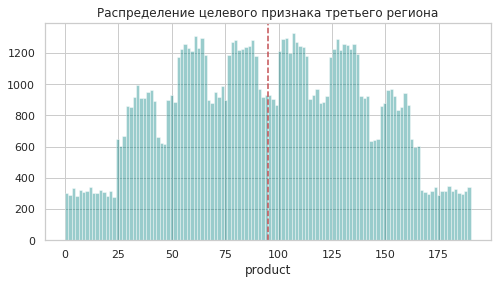

In [11]:
plt.figure(figsize=(8,4))
plt.title('Распределение целевого признака первого региона')
sns.distplot(geo_data_0['product'], color="Teal", kde=False, bins=120)
plt.axvline(np.mean(geo_data_0['product']),color='r', linestyle='--', label='product среднее')

plt.figure(figsize=(8,4))
plt.title('Распределение целевого признака второго региона')
sns.distplot(geo_data_1['product'], color="Teal", kde=False, bins=120)
plt.axvline(np.mean(geo_data_1['product']),color='r', linestyle='--', label='product среднее')


plt.figure(figsize=(8,4))
plt.title('Распределение целевого признака третьего региона')
sns.distplot(geo_data_2['product'], color="Teal", kde=False, bins=120)
plt.axvline(np.mean(geo_data_2['product']),color='r', linestyle='--', label='product среднее')


Из графиков видно, что целевой признак второго региона распределен как несколько равных по размеру групп с одинаковым значением. <br>Признаки первого и третьего регионов распределены более нормально. <br>
Возможно метод сбора данных для второго региона содержал в себе классифицирование, что не очень хорошо для построения модели регрессии. <br>

In [12]:
class_frequency = geo_data_1['product'].value_counts()
class_frequency

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

Рассмотрим корелляцию признаков, нет ли зависимых друг от друга. 

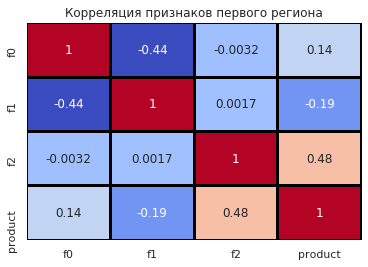

In [13]:
plt.figure(figsize=(6,4))
plt.title('Корреляция признаков первого региона')
sns.heatmap(geo_data_0.corr(), annot = True, cmap='coolwarm',
            linecolor='black', linewidths=2, cbar=False)

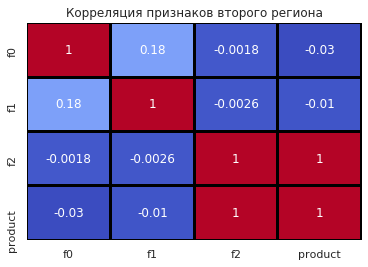

In [14]:
plt.figure(figsize=(6,4))
plt.title('Корреляция признаков второго региона')
sns.heatmap(geo_data_1.corr(), annot = True, cmap='coolwarm',
            linecolor='black', linewidths=2, cbar=False)

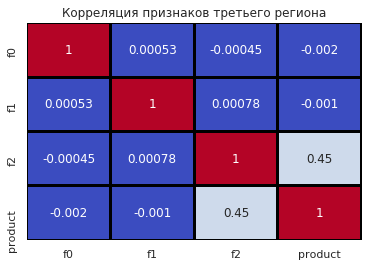

In [15]:
plt.figure(figsize=(6,4))
plt.title('Корреляция признаков третьего региона')
sns.heatmap(geo_data_2.corr(), annot = True, cmap='coolwarm',
            linecolor='black', linewidths=2, cbar=False)

По второму региону имеется максимально сильная корреляция между признаком f2 и целевым признаком. <br>По другим регионам такой корреляции нет, что говорит о том, что в данных могла быть ошибка и, возможно, им не стоит полностью доверять. <br>
Надо заметить, что при такой корреляции эта модель обучится предсказывать максимально точно.

**Вывод** <br>
Мы загрузили и рассмотрели данные по трем регионам. Каждый датасет содержит 10 000 строк без пропусков, из них три признака и столбец "Объем запасов в скважине". <br>
По второму региону данные по объему запасов вызывают сомнения,  так как содержат всего 12 уникальных значений и полностью коррелируют со столбцом f2.

## Обучение и проверка модели

Создадим табличку для записи переменных

In [16]:
targets = pd.DataFrame()
preds = pd.DataFrame()

d = {'Метрика': ['RMSE', 'Средний запас']}
metrics1 = pd.DataFrame(data=d)

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.<br>
Удалим так же уникальный столбец id, для построения модели он не нужен.<br>
Модель, которую будем использовать - линейная регрессия. 

In [17]:
def fit_model(data, count):   
    
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    model = LinearRegression()
    #обучим модель
    model.fit(features, target) 
    #получим предсказания
    predictions_valid = model.predict(features_valid)
    
    #рассчитаем метрики RMSE и средний запас product
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5    
    mean_target = target.mean()   
    
    #сохраним данные
    targets[count] = target_valid
    preds[count] = predictions_valid
    
    #запишем в табличку
    col = ('Регион ' + str(count))
    metrics1.loc[0, col] = round(rmse, 3)
    metrics1.loc[1, col] = round(mean_target, 2)
 

Построим модели по трем регионам

In [18]:
fit_model(geo_data_0, 0)
fit_model(geo_data_1, 1)
fit_model(geo_data_2, 2)

In [19]:
metrics1

,Метрика,Регион 0,Регион 1,Регион 2
0,RMSE,37.575,0.893,40.027
1,Средний запас,92.500,68.830,95.000


**Вывод** <br>
Мы создали и обучили модели линейной регрессии по всем трем регионам и получили предсказания. <br>

Лучший показатель метрики RMSE у модели по второму региону, отклонения почти нет. 
Лучший средний запас сырья у третьего региона. 

## Подготовка к расчёту прибыли

Исследуем 500 случайных точек, из которых выберем 200 лучших для разработки. 

Ключевые значения для расчётов сохраним в отдельных переменных.

Бюджет на разработку скважин в регионе - 10 млрд рублей.<br>
Доход с каждой единицы продукта - 450 тыс. рублей <br>
product - объём запасов в скважине (тыс. баррелей)<br>

In [20]:
income_per_product = 450000
budget = 10**10
count_mines = 500
count_top_mines = 200

**Расчет достаточного объём сырья для безубыточной разработки новой скважины:**

Бюджет на 200 скважин составляет 10 млрд. руб.
Рассчитаем бюджет на одну скважину.

In [21]:
budget_per_mine = budget/count_top_mines
print('Бюджет на одну скважину: {:.0f} рублей'.format(budget_per_mine))


Бюджет на одну скважину: 50000000 рублей


Объем сырья для безубыточной разработки должен составлять не менее:

In [22]:
volume_per_mine = budget_per_mine/income_per_product
print('Минимальный объем на одну скважину:', round(volume_per_mine,2), 'тыс. баррелей')

Минимальный объем на одну скважину: 111.11 тыс. баррелей


Сравним со средними запасами по регионам:

In [23]:
metrics1

,Метрика,Регион 0,Регион 1,Регион 2
0,RMSE,37.575,0.893,40.027
1,Средний запас,92.500,68.830,95.000


**Вывод** <br>
Для достижения точки безубыточности средний запас должен составлять 111 тыс. баррелей. Ни один регион не дотягивает до цифры 111 по среднему запасу продукта. 

## Расчёт прибыли по выбранным скважинам и предсказаниям модели:

Функция для расчета прибыли по выбранным скважинам.

In [37]:
def revenue(target, predictions, count):
   
    predictions = pd.Series(predictions, index=target.index)    
    #Выберем скважины с максимальными значениями предсказаний:
    predictions_sorted = predictions.sort_values(ascending=False)[:count_top_mines]
    #Просуммируем целевое значение сырья, соответствующее этим предсказаниям
    selected = target[predictions_sorted.index]
    sum_product = selected.sum()    
    #Рассчитаем прибыль для полученного объема сырья
    result = income_per_product * sum_product - budget
    return result

Прибыль для полученного объёма сырья:

In [25]:
d = {'Метрика': ['Целевая прибыль, млрд. руб', 
                 'Средняя прибыль, млрд. руб', 'Риск убытков, %']}
metrics = pd.DataFrame(data=d)
metrics = metrics1.append(metrics).reset_index(drop=True)

In [26]:
targets = targets.reset_index(drop=True)
revenue_0 = revenue(targets[0], preds[0], count_top_mines)/10**9
print('Прибыль первого региона: {:.2f} млрд рублей'.format(revenue_0))
revenue_1 = revenue(targets[1], preds[1], count_top_mines)/10**9
print('Прибыль второго региона: {:.2f} млрд рублей'.format(revenue_1))
revenue_2 = revenue(targets[2], preds[2], count_top_mines)/10**9
print('Прибыль третьего региона: {:.2f} млрд рублей'.format(revenue_2))

Прибыль первого региона: 3.32 млрд рублей
Прибыль второго региона: 2.42 млрд рублей
Прибыль третьего региона: 2.73 млрд рублей


In [32]:
metrics.loc[2, 'Регион 0'] = round(revenue_0, 3)
metrics.loc[2, 'Регион 1'] = round(revenue_1, 3)
metrics.loc[2, 'Регион 2'] = round(revenue_2, 3)
metrics

,Метрика,Регион 0,Регион 1,Регион 2
0,RMSE,37.575,0.893,40.027
1,Средний запас,92.500,68.830,95.000
2,"Целевая прибыль, млрд. руб",3.321,2.415,2.732
3,"Средняя прибыль, млрд. руб",0.601,0.665,0.617
4,"Риск убытков, %",2.100,0.300,3.100


**Вывод** <br>
Мы исследовали 500 точек для разработки скважин и отобрали 200 лучших из них. <br>
Прибыль по этим точкам составила 3.321 млрд. руб для первого региона,  2.415 для второго и 2.732 для третьего. Лучшая прибыль у первого региона. 

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.


In [34]:
targets = targets.reset_index(drop=True)
state = np.random.RandomState(12345) 
values = []
for i in range(1000):
    target_subsample = pd.Series(targets[0]).sample(count_mines, replace=True, random_state=state)
    probs_subsample = pd.Series(preds[0])[target_subsample.index]
    values.append(revenue(target_subsample, probs_subsample, count_top_mines))

values = pd.Series(values)
mean = values.mean()
risk_of_loss = values[values<0].count()/len(values)*100

print('Средняя прибыль первого региона: {:.2f} млрд рублей'.format(mean/10**9))

confidence_interval =  st.t.interval(
    0.95, len(values)-1, mean/10**9, values.sem()/10**9) 

print("95%-ый доверительный интервал:", confidence_interval)
print("Риск убытков", risk_of_loss, '%')

metrics.loc[3, 'Регион 0'] = round(mean/10**9, 3)
metrics.loc[4, 'Регион 0'] = risk_of_loss


Средняя прибыль первого региона: 0.43 млрд рублей
95%-ый доверительный интервал: (0.41004796202303684, 0.44447706320639313)
Риск убытков 6.0 %


In [35]:
targets = targets.reset_index(drop=True)
state = np.random.RandomState(12345) 
values = []
for i in range(1000):
    target_subsample = pd.Series(targets[1]).sample(count_mines, replace=True, random_state=state)
    probs_subsample = pd.Series(preds[1])[target_subsample.index]
    values.append(revenue(target_subsample, probs_subsample, count_top_mines))

values = pd.Series(values)
mean = values.mean()
risk_of_loss = values[values<0].count()/len(values)*100

print('Средняя прибыль второго региона : {:.2f} млрд рублей'.format(mean/10**9))

confidence_interval =  st.t.interval(
    0.95, len(values)-1, mean/10**9, values.sem()/10**9) 

print("95%-ый доверительный интервал:", confidence_interval)
print("Риск убытков", risk_of_loss, '%')

metrics.loc[3, 'Регион 1'] = round(mean/10**9, 3)
metrics.loc[4, 'Регион 1'] = risk_of_loss


Средняя прибыль второго региона : 0.52 млрд рублей
95%-ый доверительный интервал: (0.5016229657067748, 0.5288254423721299)
Риск убытков 1.0 %


In [36]:
targets = targets.reset_index(drop=True)
state = np.random.RandomState(12345) 
values = []
for i in range(1000):
    target_subsample = pd.Series(targets[2]).sample(count_mines, replace=True, random_state=state)
    probs_subsample = pd.Series(preds[2])[target_subsample.index]
    values.append(revenue(target_subsample, probs_subsample, count_top_mines))

values = pd.Series(values)
mean = values.mean()
risk_of_loss = values[values<0].count()/len(values)*100


print('Средняя прибыль третьего региона : {:.2f} млрд рублей'.format(mean/10**9))

confidence_interval =  st.t.interval(
    0.95, len(values)-1, mean/10**9, values.sem()/10**9) 

print("95%-ый доверительный интервал:", confidence_interval)
print("Риск убытков", risk_of_loss, '%')

metrics.loc[3, 'Регион 2'] = round(mean/10**9, 3)
metrics.loc[4, 'Регион 2'] = risk_of_loss



Средняя прибыль третьего региона : 0.44 млрд рублей
95%-ый доверительный интервал: (0.4190146118864122, 0.4541147065400758)
Риск убытков 6.4 %


In [31]:
metrics

,Метрика,Регион 0,Регион 1,Регион 2
0,RMSE,37.575,0.893,40.027
1,Средний запас,92.500,68.830,95.000
2,"Целевая прибыль, млрд. руб",3.321,2.415,2.732
3,"Средняя прибыль, млрд. руб",0.601,0.665,0.617
4,"Риск убытков, %",2.100,0.300,3.100


**Вывод**
С помощью техники Bootstrap мы оценили распределение вероятности прибыли, доверительный интервал и риск убытков. <br>
Средняя прибыль оказалась наибольшей у второго региона с минимальным риском убытков. <br>
По третьему региону риск убытков превышает 2,5%, что заставляет исключить его из рассмотрения. <br>


## Общий вывод

Мы исследовали характеристики скважин по трем регионам, построили и обучили модели. 
Из десяти тысяч записей отобрали 500 случайных точек для разработки скважины и выбрали 200 из них с максимальными запасами сырья, а так же нашли общую прибыль по каждому региону с учетом нашего бюджета. 

Лучшей моделью оказалась модель для второго региона, с самой низкой метрикой RMSI.
Однако полученные по этому региону данные выглядят не вполне достоверными, так как столбец с запасами сырья содержит всего двенадцать уникальных значений, которые полностью зависят от признака f2 и корреллируют с ним. 

Так же мы нашли распределение прибыли и среднее значение прибыли по каждому региону. 
Средняя прибыль по первому региону - 0.60, по второму - 0.66, по третьему - 0.61 млрд. руб. 
Риск убытков при этом составляет 2.1% для первого региона, 0.3% для второго, и 3.1% для третьего. 

Максимальный риск убытков, который мы можем себе позволить, составляет 2,5%, так что третий регион придется исключить. 
Прибыль максимальна по второму региону, а так же минимальный риск убытков, близкий к нулю. Однако это, несомненно, связано с особенностями полученных данных, поэтому, без дополнительного исследования или пояснений, мы не можем рекомендовать этот регион. 

Для разработки остается первый регион, хотя там и наименьшая средняя прибыль из трех, но риск убытков в пределах нормы. 